In [1]:
# load libraries
import xarray as xr
from minisom import MiniSom
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.gridspec import GridSpec
from sklearn.preprocessing import MinMaxScaler, scale
import numpy as np


## Open and Explore data

Air temperature data from the US

In [2]:
# open xarray tutorial dataset
ds = xr.tutorial.open_dataset("air_temperature.nc").rename({"air": "Tair"})
print(ds)

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    Tair     (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...


In [3]:
print(ds.description)

Data is from NMC initialized reanalysis
(4x/day).  These are the 0.9950 sigma level values.


(array([   2182.,   60537.,  195026.,  233763.,  315219.,  635948.,
         778807., 1192236.,  453381.,    1901.]),
 array([221.     , 230.64   , 240.28   , 249.92   , 259.56   , 269.2    ,
        278.84   , 288.47998, 298.12   , 307.76   , 317.4    ],
       dtype=float32),
 <a list of 10 Patch objects>)

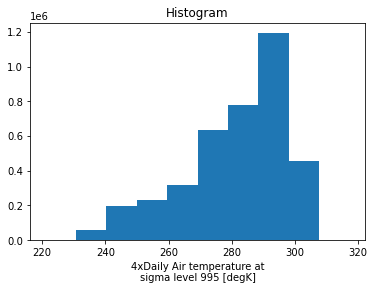

In [4]:
# plot histogram
ds.Tair.plot()

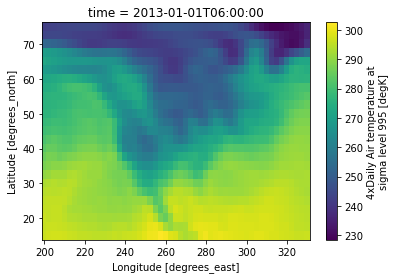

In [5]:
# plot at initial time
ds.Tair.isel(time=1).plot()

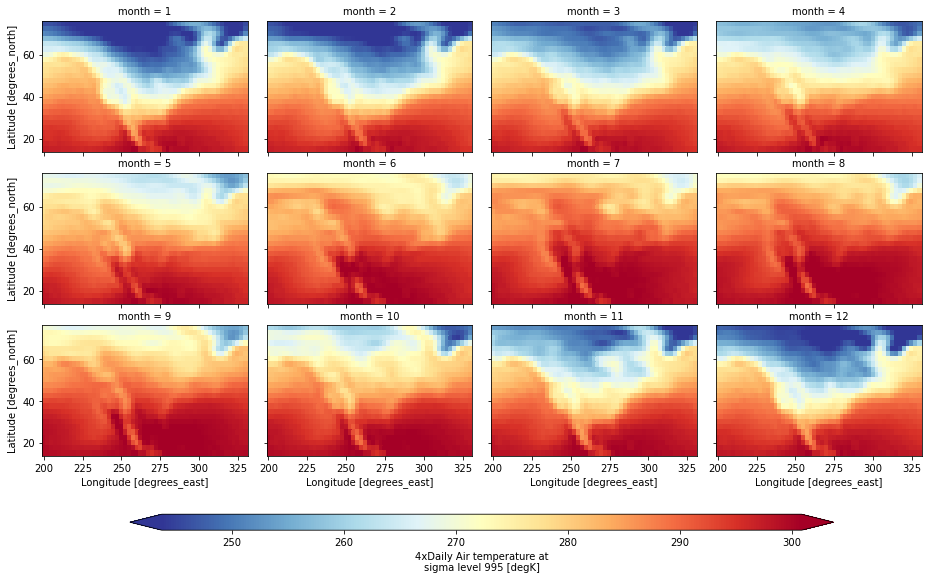

In [6]:
# group by month and plot it:
monthly_means = ds.groupby("time.month").mean()
# xarray's groupby reductions drop attributes. Let's assign them back so we get nice labels.
monthly_means.Tair.attrs = ds.Tair.attrs

fg = monthly_means.Tair.plot(
    col="month",
    col_wrap=4,  # each row has a maximum of 4 columns
        # The remaining kwargs customize the plot just as for not-faceted plots
    robust=True,
    cmap=mpl.cm.RdYlBu_r,
    cbar_kwargs={
        "orientation": "horizontal",
        "shrink": 0.8,
        "aspect": 40,
        "pad": 0.1,
    },
)


# SOM Clustering

We will apply SOM first on time domain, that is, find spatial clusters that are correlated in time, and later in spatial domain. 

In [7]:
# define SOM parameters
som_map = (3,3) # we will try a 3x3 neural map
x,y=som_map
sigma = 1 # default value
learning_rate = 0.5 # default value
ngb_function = 'gaussian' # choosing between ['gaussian' ,'bubble','mexican_hat']
init = 'random' # we will initialize SOM randomly. Option: 'pca'
train = 'batch' # perform batch traning instead of random (default)
iterations = 10000 # lenght of training
topology = 'hexagonal' # to ensure equidistant ditance neighbors
activation_distance = 'euclidean'


In [8]:
ds

<xarray.Dataset>
Dimensions:  (lat: 25, lon: 53, time: 2920)
Coordinates:
  * lat      (lat) float32 75.0 72.5 70.0 67.5 65.0 ... 25.0 22.5 20.0 17.5 15.0
  * lon      (lon) float32 200.0 202.5 205.0 207.5 ... 322.5 325.0 327.5 330.0
  * time     (time) datetime64[ns] 2013-01-01 ... 2014-12-31T18:00:00
Data variables:
    Tair     (time, lat, lon) float32 ...
Attributes:
    Conventions:  COARDS
    title:        4x daily NMC reanalysis (1948)
    description:  Data is from NMC initialized reanalysis\n(4x/day).  These a...
    platform:     Model
    references:   http://www.esrl.noaa.gov/psd/data/gridded/data.ncep.reanaly...

In [9]:
data_in=np.array(ds['Tair'])
dimlon=len(ds['lon'])
dimlat= len(ds['lat'])
dimtime = len(ds['time'])

In [10]:
print(data_in.shape)

(2920, 25, 53)


In [11]:
# data preprocessing

# we need to concatenate the dataset to 2D:
data=data_in.reshape(dimtime,dimlat*dimlon)

# normalize dataset:
# using MinMaxScaler
# sc = MinMaxScaler (feature_range = (0,1))
# data_norm = sc.fit_transform (data)
# scale data
# X_scale= scale(data.T)
# manually
data = (data - np.nanmean(data, axis=0)) / np.nanstd(data, axis=0)


## Time domain

In [12]:
# to analyse in time domain we need to transpose it:
X = data.T
input_len=X.shape[1]

# create som
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)
# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

 [   229 / 10000 ]   2% - 0:00:03 left 

 [   588 / 10000 ]   6% - 0:00:03 left 

 [   844 / 10000 ]   8% - 0:00:03 left 

 [  1223 / 10000 ]  12% - 0:00:02 left 

 [  1464 / 10000 ]  15% - 0:00:02 left 

 [  1855 / 10000 ]  19% - 0:00:02 left 

 [  2112 / 10000 ]  21% - 0:00:02 left 

 [  2489 / 10000 ]  25% - 0:00:02 left 

 [  2740 / 10000 ]  27% - 0:00:02 left 

 [  3110 / 10000 ]  31% - 0:00:02 left 

 [  3350 / 10000 ]  34% - 0:00:02 left 

 [  3728 / 10000 ]  37% - 0:00:02 left 

 [  3970 / 10000 ]  40% - 0:00:01 left 

 [  4355 / 10000 ]  44% - 0:00:01 left 

 [  4607 / 10000 ]  46% - 0:00:01 left 

 [  4987 / 10000 ]  50% - 0:00:01 left 

 [  5254 / 10000 ]  53% - 0:00:01 left 

 [  5626 / 10000 ]  56% - 0:00:01 left 

 [  5890 / 10000 ]  59% - 0:00:01 left 

 [  6280 / 10000 ]  63% - 0:00:01 left 

 [  6538 / 10000 ]  65% - 0:00:01 left 

 [  6909 / 10000 ]  69% - 0:00:00 left 

 [  7153 / 10000 ]  72% - 0:00:00 left 

 [  7516 / 10000 ]  75% - 0:00:00 left 

 [  7760 / 10000 ]  78% - 0:00:00 left 

 [  8142 / 10000 ]  81% - 0:00:00 left 

 [  8415 / 10000 ]  84% - 0:00:00 left 

 [  8782 / 10000 ]  88% - 0:00:00 left 

 [  9029 / 10000 ]  90% - 0:00:00 left 

 [  9417 / 10000 ]  94% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 29.1143042357806


### Clusters of different temporal variability
Considering the time series 3x3 SOM analysis

Requested network: 3x3
 Identified: 9 regions


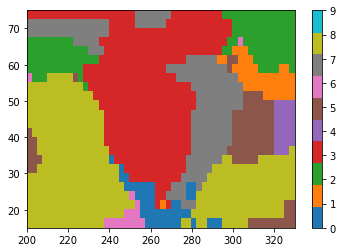

In [13]:
# extract clusters of winning neurons:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (x,y))
# cluster_index=winner_coordinates[1,:]
n_cluster=len(np.unique(cluster_index))
print('Requested network: {}x{}\n Identified: {} regions'.format(x,y,n_cluster))
plt.pcolor(ds.lon,ds.lat,cluster_index.reshape(dimlat,dimlon),
           vmin=0,vmax=x*y,cmap='tab10');
plt.colorbar()
plt.show()

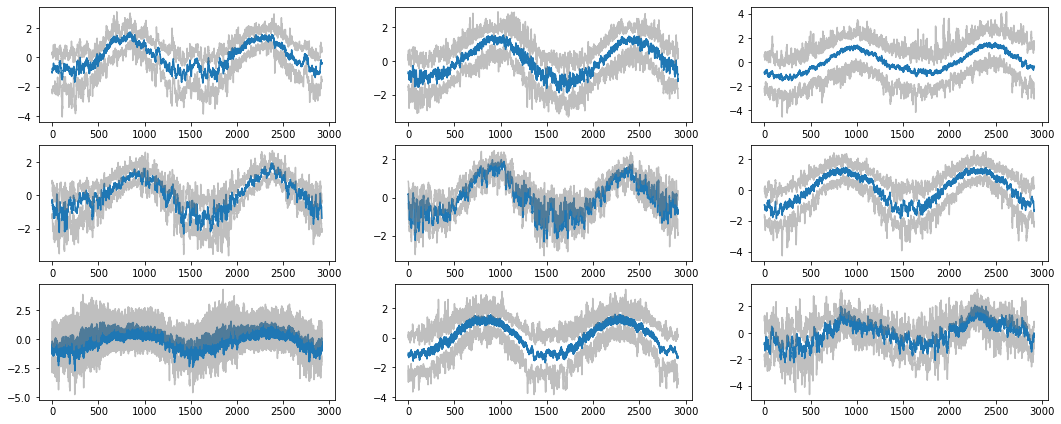

In [14]:
# extract time series of each cluster
win_map = som.win_map(X)
win_ts=np.zeros((len(win_map),input_len,3))
# cluster_index = np.ravel_multi_index(win_ts, (x,y))

# plto time series
plt.figure(figsize=(50, 20))
the_grid = GridSpec(8, 8)

for i,position in enumerate(win_map.keys()):
    win_ts[i,:,0]=np.min(win_map[position], axis=0) 
    win_ts[i,:,1]=np.mean(win_map[position], axis=0)
    win_ts[i,:,2]=np.max(win_map[position], axis=0)
    
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.plot(np.min(win_map[position], axis=0), color='gray', alpha=.5)
    plt.plot(np.mean(win_map[position], axis=0))
    plt.plot(np.max(win_map[position], axis=0), color='gray', alpha=.5)
    
plt.show()

## Space domain

In [15]:
# to analyse in time domain we need to transpose it:
X = data
input_len=X.shape[1]

# create som
som = MiniSom(x=x,y=y,input_len=input_len,
                    sigma=sigma,learning_rate=learning_rate,
                    neighborhood_function=ngb_function,
                    topology=topology,
                    activation_distance=activation_distance,
                    random_seed=None)
# init som
if init=='pca':
    som.pca_weights_init(X)
else:
    som.random_weights_init(X)

# train som
if train=='random':
    som.train_random(X,iterations,verbose=True)
else:
    som.train_batch(X,iterations,verbose=True)

 [   896 / 10000 ]   9% - 0:00:02 left 

 [  1802 / 10000 ]  18% - 0:00:01 left 

 [  2751 / 10000 ]  28% - 0:00:01 left 

 [  3709 / 10000 ]  37% - 0:00:01 left 

 [  4662 / 10000 ]  47% - 0:00:01 left 

 [  5614 / 10000 ]  56% - 0:00:00 left 

 [  6541 / 10000 ]  65% - 0:00:00 left 

 [  7466 / 10000 ]  75% - 0:00:00 left 

 [  8285 / 10000 ]  83% - 0:00:00 left 

 [  9186 / 10000 ]  92% - 0:00:00 left 

 [ 10000 / 10000 ] 100% - 0:00:00 left 


 quantization error: 23.971422068680223


In [16]:
# extract clusters of winning neurons:
# each neuron represents a cluster
winner_coordinates = np.array([som.winner(x) for x in X]).T
# with np.ravel_multi_index we convert the bidimensional
# coordinates to a monodimensional index
cluster_index = np.ravel_multi_index(winner_coordinates, (x,y))
# cluster_index=winner_coordinates[1,:]
n_cluster=len(np.unique(cluster_index))
print('Requested network: {}x{}\n Identified: {} regions'.format(x,y,n_cluster))
# plt.pcolor(ds.lon,ds.lat,cluster_index.reshape(dimlat,dimlon),
#           vmin=0,vmax=x*y,cmap='tab10');
# plt.colorbar()
# plt.show()

Requested network: 3x3
 Identified: 9 regions


### Spatial patterns of a 3x3 SOM

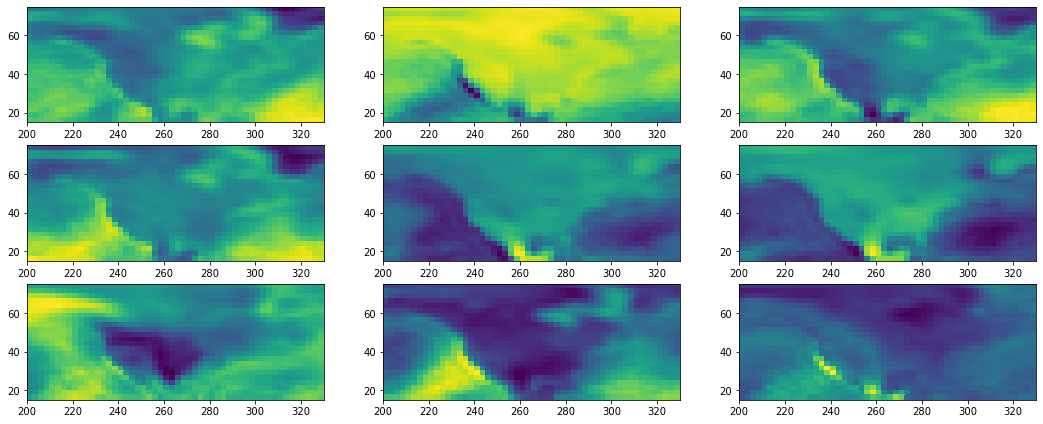

In [17]:
# extract results
win_map = som.win_map(data)
win_ts=np.zeros((len(win_map),input_len,3))
# cluster_index = np.ravel_multi_index(win_ts, (x,y))

plt.figure(figsize=(50, 20))
the_grid = GridSpec(8,8)

for i,position in enumerate(win_map.keys()):
    win_ts[i,:,0]=np.min(win_map[position], axis=0)
    win_ts[i,:,1]=np.mean(win_map[position], axis=0)
    win_ts[i,:,2]=np.max(win_map[position], axis=0)

    
    # plt.plot(win_ts[:,:,0].T);plt.show()
    # plot spatial pattern of each neuron
    plt.subplot(the_grid[6-position[1], position[0]])
    plt.pcolor(ds.lon,ds.lat,win_ts[i,:,1].reshape(dimlat,dimlon));
plt.show()

# Reference

Hernandez-Carrasco, I., & Orfila, A. (2018). The role of an intense front on the connectivity of the western Mediterranean Sea: The Cartagena- Tenes front. Journal of Geophysical Research: Oceans, 123, 4398–4422. https://doi.org/10.1029/2017JC013613